# Install & Upgrade Library

In [ ]:
pip install gdown

In [ ]:
# import tensorflow as tf

# print("TensorFlow version:", tf.__version__)
# print("Keras version:", tf.keras.__version__)

# Import Libary

In [ ]:
import numpy as np
import gdown
import os
import shutil
import seaborn as sns
import zipfile
import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Dropout,GlobalAveragePooling2D
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications import MobileNetV3Small

# Download dataset

In [ ]:
file_id = "1DmxyThqOg4QBYCY_d1FglBtYZyniGdos"

# URL berbagi dari Google Drive
url = 'https://drive.google.com/uc?id=' + file_id

# Path untuk menyimpan file yang diunduh
output = 'dataset.zip'

# Mengunduh file
gdown.download(url, output, quiet=False)

# Mengekstrak file zip jika diperlukan
import zipfile

with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall('datasets/')

Downloading...
From (original): https://drive.google.com/uc?id=1DmxyThqOg4QBYCY_d1FglBtYZyniGdos
From (redirected): https://drive.google.com/uc?id=1DmxyThqOg4QBYCY_d1FglBtYZyniGdos&confirm=t&uuid=717146cd-e82a-4f21-8950-562fca438abb
To: /content/dataset.zip
100%|██████████| 658M/658M [00:07<00:00, 91.8MB/s]


# Preprocessing

## Load and Clean Dataset

In [ ]:
def check_and_remove_invalid_images(root_dir):
    invalid_files = []
    for subdir, dirs, files in os.walk(root_dir):
        for file in files:
            file_path = os.path.join(subdir, file)
            try:
                with Image.open(file_path) as img:
                    img.verify()  # Attempt to open and verify the image
            except Exception as e:
                print(f"Error processing image: {file_path} - {e}")
                invalid_files.append(file_path)
    # Remove invalid files
    for invalid_file in invalid_files:
        os.remove(invalid_file)
        print(f"Invalid image removed: {invalid_file}")

In [ ]:
def get_file_paths_and_labels(root_dir):
    # Check and remove invalid images before collecting file paths and labels
    check_and_remove_invalid_images(root_dir)

    file_paths = []
    labels = []
    for subdir, dirs, files in os.walk(root_dir):
        for file in files:
            file_path = os.path.join(subdir, file)
            label = os.path.basename(subdir)
            file_paths.append(file_path)
            labels.append(label)
    return file_paths, labels

In [ ]:
# Direktori asal, train, dan validation
kaggle_prefix_dir = '/kaggle/working/'
colab_prefix_dir = '/content/'
prefix_dir = colab_prefix_dir

root_dir = prefix_dir + 'datasets/'
train_dir = prefix_dir + 'final-datasets/train'
val_dir = prefix_dir + 'final-datasets/valid'

# Membuat direktori train dan validation jika belum ada
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

# Mendapatkan semua jalur file dan labelnya
file_paths, labels = get_file_paths_and_labels(root_dir)

## Split Dataset

In [ ]:
def split_and_move_files(file_paths, labels, train_dir, val_dir, test_size=0.2):
    X_train, X_val, y_train, y_val = train_test_split(file_paths, labels, test_size=test_size, stratify=labels, random_state=234)

    for file_path, label in zip(X_train, y_train):
        label_dir = os.path.join(train_dir, label)
        os.makedirs(label_dir, exist_ok=True)
        shutil.copy(file_path, label_dir)

    for file_path, label in zip(X_val, y_val):
        label_dir = os.path.join(val_dir, label)
        os.makedirs(label_dir, exist_ok=True)
        shutil.copy(file_path, label_dir)

In [ ]:
# Membagi dan memindahkan file ke direktori train dan validation
split_and_move_files(
    file_paths,
    labels,
    train_dir,
    val_dir,
    test_size=0.2
    )

## Data Generator and Augmentation

In [ ]:
# ImageDataGenerator untuk training dan validation
train_datagen = ImageDataGenerator(
	  rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
val_datagen = ImageDataGenerator(
)

# Membuat generator untuk training dan validation
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 5124 images belonging to 31 classes.
Found 1282 images belonging to 31 classes.


# Modeling

In [ ]:
def plot_history(history):
    # Menyimpan history
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epochs = range(1, len(loss) + 1)

    # Plotting loss
    plt.figure(figsize=(12, 5))

    # Plotting Training and Validation Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()


    plt.tight_layout()
    plt.show()

In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Memonitor akurasi validasi
    patience=5,              # Berhenti jika tidak ada perbaikan setelah 5 epoch
    verbose=1,               # Menampilkan informasi ketika berhenti
    restore_best_weights=True # Mengembalikan bobot terbaik
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=3e-7
)

In [ ]:
mobilenet_v3_small_model = MobileNetV3Small(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
mobilenet_v3_small_model.trainable= False

4334752/4334752 [==============================] - 1s 0us/step


In [ ]:
# model = Sequential([
#     mobilenet_v3_small_model,
#     GlobalAveragePooling2D(),
#     Dropout(0.2),
#     Dense(512, activation='relu'),
#     Dropout(0.2),
#     Dense(256, activation='relu'),
#     Dense(64, activation='relu'),
#     Dense(31, activation='softmax')
# ])

# optimizer = Adam(learning_rate=3e-5)
# model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# history = model.fit(
#     train_generator,
#     validation_data=validation_generator,
#     epochs=20,
#     batch_size = 32,
#     verbose=2,
# #     callbacks=[early_stopping],
# )

In [ ]:
# plot_history(history)

# Fine Tuning

In [ ]:
mobilenet_v3_small_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(mobilenet_v3_small_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in mobilenet_v3_small_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  229


In [ ]:
model = Sequential([
    mobilenet_v3_small_model,
    # GlobalAveragePooling2D(),
    # Dropout(0.2),
    # Dense(512, activation='relu'),
    # Dropout(0.2),
    # Dense(256, activation='relu'),
    # Dense(64, activation='relu'),
    # Dense(31, activation='softmax')
    GlobalAveragePooling2D(),
    Dropout(0.2),
    Dense(31, activation='softmax')
])

optimizer = Adam(learning_rate=3e-4)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
print("Input shape dari model:", model.input_shape)

Input shape dari model: (None, 224, 224, 3)


In [ ]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    batch_size = 32,
    verbose=2,
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


161/161 - 120s - loss: 1.9311 - accuracy: 0.4688 - val_loss: 1.4745 - val_accuracy: 0.5351 - lr: 3.0000e-04 - 120s/epoch - 745ms/step
Epoch 2/30
161/161 - 94s - loss: 0.7112 - accuracy: 0.7793 - val_loss: 1.2686 - val_accuracy: 0.6076 - lr: 3.0000e-04 - 94s/epoch - 582ms/step
Epoch 3/30
161/161 - 92s - loss: 0.4915 - accuracy: 0.8450 - val_loss: 0.8713 - val_accuracy: 0.7161 - lr: 3.0000e-04 - 92s/epoch - 570ms/step
Epoch 4/30
161/161 - 92s - loss: 0.3782 - accuracy: 0.8825 - val_loss: 0.7782 - val_accuracy: 0.7543 - lr: 3.0000e-04 - 92s/epoch - 570ms/step
Epoch 5/30
161/161 - 92s - loss: 0.3222 - accuracy: 0.8956 - val_loss: 0.6233 - val_accuracy: 0.8042 - lr: 3.0000e-04 - 92s/epoch - 574ms/step
Epoch 6/30
161/161 - 91s - loss: 0.2696 - accuracy: 0.9126 - val_loss: 0.5015 - val_accuracy: 0.8346 - lr: 3.0000e-04 - 91s/epoch - 565ms/step
Epoch 7/30
161/161 - 91s - loss: 0.2337 - accuracy: 0.9264 - val_loss: 0.3653 - val_accuracy: 0.8822 - lr: 3.0000e-04 - 91s/epoch - 563ms/step
Epoch 8/

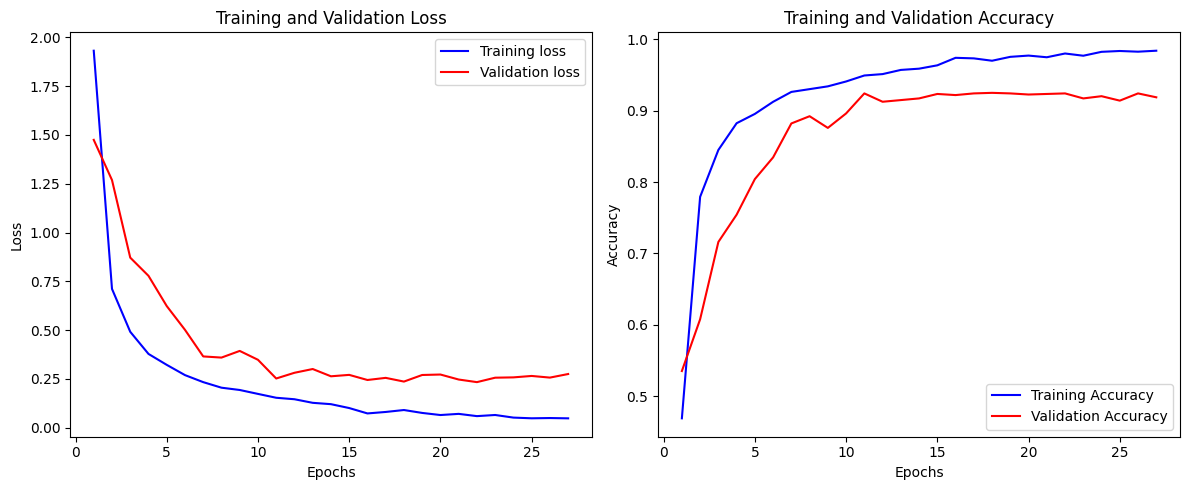

In [ ]:
plot_history(history)

# Save model

## Save class indices

In [ ]:
np.save('class_indices.npy', train_generator.class_indices)

## Save as h5 model

In [ ]:
model.save('mobilenet_v3_small.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Save as saved model

In [ ]:
saved_model_dir = 'saved_model_mobilenet_v3_small'
# tf.saved_model.save(model, saved_model_dir)

## Convert to Tflite

In [ ]:
!pip uninstall tensorflow
!pip install tensorflow=="2.13.0"

Found existing installation: tensorflow 2.15.0
Uninstalling tensorflow-2.15.0:
  Would remove:
    /usr/local/bin/estimator_ckpt_converter
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.15.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? y
  Successfully uninstalled tensorflow-2.15.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 87.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 73.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 86.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 50.5 MB/s eta 0:00:00
  Attempting uninstall: typ

In [ ]:
pip install tflite-support

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 MB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.0/235.0 kB 24.4 MB/s eta 0:00:00


In [ ]:
class_indices = np.load('class_indices.npy', allow_pickle=True).item()

with open('class_labels.txt', 'w') as f:
    for class_name in class_indices:
        f.write(f"{class_name}\n")

In [ ]:
from tflite_support.metadata_writers import image_classifier
from tflite_support.metadata_writers import writer_utils

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
# converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Mengonversi model ke format TFLite
tflite_model = converter.convert()

# Save the model to a file
with open('mobilenet_v3.tflite', 'wb') as f:
    f.write(tflite_model)

# Create metadata for the mobilenet_v3
writer = image_classifier.MetadataWriter.create_for_inference(
    writer_utils.load_file('mobilenet_v3.tflite'),
    input_norm_mean=[0],  # Mean value for normalization (0 means no normalization)
    input_norm_std=[1],   # Standard deviation for normalization (1 means no normalization)
    label_file_paths=['class_labels.txt']
)

# Populate the metadata into the mobilenet_v3 file
writer_utils.save_file(writer.populate(), 'mobilenet_v3_with_metadata.tflite')


# Make Prediction

In [ ]:
class_indices = np.load('class_indices.npy', allow_pickle=True).item()
class_labels = {v: k for k, v in class_indices.items()}
class_labels

{0: 'adas',
 1: 'andaliman',
 2: 'asam jawa',
 3: 'bawang bombai',
 4: 'bawang merah',
 5: 'bawang putih',
 6: 'biji ketumbar',
 7: 'bukan rempah',
 8: 'bunga lawang',
 9: 'cengkeh',
 10: 'daun jeruk',
 11: 'daun kemangi',
 12: 'daun ketumbar',
 13: 'daun salam',
 14: 'jahe',
 15: 'jinten',
 16: 'kapulaga',
 17: 'kayu manis',
 18: 'kayu secang',
 19: 'kemiri',
 20: 'kemukus',
 21: 'kencur',
 22: 'kluwek',
 23: 'kunyit',
 24: 'lada',
 25: 'lengkuas',
 26: 'pala',
 27: 'saffron',
 28: 'serai',
 29: 'vanili',
 30: 'wijen'}

In [ ]:
model = load_model('mobilenet_v3_small.h5')

In [ ]:
from sklearn.metrics import classification_report

test_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=32,
    shuffle=False,
    class_mode='categorical'
)


y_true = test_generator.classes

y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Hitung metrik
report = classification_report(y_true, y_pred_classes)
print(report)

Found 1282 images belonging to 31 classes.
41/41 [==============================] - 22s 511ms/step
              precision    recall  f1-score   support

           0       0.97      0.90      0.94        42
           1       0.95      0.97      0.96        39
           2       0.91      1.00      0.95        40
           3       1.00      1.00      1.00        41
           4       0.98      1.00      0.99        41
           5       1.00      0.98      0.99        41
           6       0.72      0.93      0.81        41
           7       0.95      0.93      0.94        40
           8       0.95      1.00      0.98        41
           9       0.92      0.88      0.90        40
          10       0.93      0.90      0.91        41
          11       0.92      0.85      0.89        41
          12       0.98      0.98      0.98        43
          13       0.83      0.91      0.87        43
          14       0.90      0.85      0.88        41
          15       0.90      0.97   

In [ ]:
from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array


# Load class indices
class_indices = np.load('class_indices.npy', allow_pickle=True).item()
class_labels = {v: k for k, v in class_indices.items()}

# Upload files
uploaded = files.upload()

# Create test folder if it doesn't exist
if not os.path.exists('test'):
    os.makedirs('test')

for fn in uploaded.keys():
    # Move the uploaded file to the test folder
    os.rename(fn, os.path.join('test', fn))
    path = os.path.join('test', fn)

    # Predicting images
    img = load_img(path, target_size=(224, 224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)

    predictions = model.predict(x)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_label = class_labels[predicted_class_index]

    # Menampilkan hasil prediksi
    print(f'Gambar {fn} diprediksi sebagai kelas: {predicted_class_label} dengan probabilitas: {predictions[0][predicted_class_index]}')

Saving adas-1.jpg to adas-1 (1).jpg
Saving bawang_bombay_1.jpg to bawang_bombay_1 (1).jpg
Saving bawang_merah_1.jpg to bawang_merah_1 (1).jpg
Saving bawang-putih_1.jpg to bawang-putih_1 (1).jpg
Saving bawang-putih_2.jpg to bawang-putih_2 (1).jpg
Saving biji_ketumbar_1.jpg to biji_ketumbar_1 (1).jpg
Saving bunga_lawang_1.jpg to bunga_lawang_1 (1).jpg
Saving cengkeh_1.png to cengkeh_1 (1).png
Saving daun_salam_1.jpg to daun_salam_1 (1).jpg
Saving daun-jeruk_1.jpg to daun-jeruk_1 (1).jpg
Saving daun-kemangi_1.jpg to daun-kemangi_1 (1).jpg
Saving jahe_1.jpg to jahe_1 (1).jpg
Saving kapulaga_1.jpg to kapulaga_1 (1).jpg
Saving kayu_manis_1.png to kayu_manis_1 (1).png
Saving kayu_manis_2.png to kayu_manis_2 (1).png
Saving kayu_secang_1.jpg to kayu_secang_1 (1).jpg
Saving kemiri_1.jpg to kemiri_1 (1).jpg
Saving kluwek_1.jpg to kluwek_1 (1).jpg
Saving kunyit_1.png to kunyit_1 (1).png
Saving kunyit_2.jpg to kunyit_2 (1).jpg
Saving lada_1.jpg to lada_1 (1).jpg
Saving lengkuas_1.jpg to lengkuas_1 